# Python Sesión 3 - Método de sobre-relajación sucesiva (SOR)

## Parte 2: Ejemplo

## IIQ2003 - Fenómenos de Transporte - Python S3

Departamento de Ingeniería Química y Bioprocesos

Pontificia Universidad Católica de Chile

Profesor: Felipe Huerta

### Enunciado

En la **Clase 12** se derivó que la ecuación que gobierna el perfil de temperatura para la convección forzada de calor en un tubo circular con un regimen de flujo laminar es:

$$ \rho \hat{c}_p v_{max} \left(1- \left( \frac{r}{R} \right)^2 \right) \frac{\partial T}{\partial z} = k \left[ \frac{1}{r} \frac{\partial}{\partial r}  \left( r \frac{\partial T}{\partial r} \right)  + \frac{\partial^2 T}{\partial z^2} \right] $$

A diferencia de la clase, **no se despreciará** el término de conducción axial $k \frac{\partial^2 T}{\partial z^2}$. Al desarrollar la derivada del lado derecho, restando el lado derecho a ambos lados de la ecuación y reordenando términos, es posible escribir la ecuación diferencial parcial (EDP) de la siguiente forma:

$$ k \frac{\partial^2 T}{\partial r ^2} + k \frac{\partial^2 T}{\partial z ^2} + \frac{k}{r} \frac{\partial T}{\partial r} - \rho \hat{c}_p v_{max} \left(1- \left( \frac{r}{R} \right)^2 \right) \frac{\partial T}{\partial z} = 0$$ 

En donde todos los términos que multiplican a las derivadas espaciales de la temperatura son constantes o funciones de la variable independiente $r$. Utilizando el método de sobrerrelajación sucesiva, encuentre el perfil bidimensional de temperatura que satisface la EDP. 

Considere que:
* El radio interno de la tubería, $R=L_r$, es 2.54 cm.
* El largo de la tubería, $L=L_z$ es 20 veces el radio
* El fluido que circula por la tubería es agua cuya conductividad térmica a la temperatura promedio es $k = 0.6$ Wm$^{-1}$K$^{-1}$, la densidad a la temperatura promedio es $\rho = 1000 kg m^{-3}$ y el calor específico evaluado a la temperatura promedio es $\hat{c}_p$ = 4180 J/kgK. La viscosidad del agua a la temperatura promedio es $\mu = 10^{-3} $ Pa$\cdot$ s.
* La temperatura del agua a la entrada del estanque es de 298.15 K
* Existe un gradiente de presión tal que la velocidad máxima a la tubería es de 0.1 mm/s.
* El agua que circula por la tubería es calentada en las paredes mediante un flux de calor radial, constante e igual a $q_w = 300$ W m$^{-2}$.

### Paso 1: Discretización de la EDP

Convierta la EDP en un sistema de ecuaciones lineales utilizando diferencias finitas.

#### Solucion:

Utilizando las ecuaciones de aproximaciones por diferencias finitas (ver páginas 18 y 19 del formulario y Clase 16), se obtiene:

$$ k \left( \frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{\Delta r^2} \right) +
k \left( \frac{T_{i,j+1} - 2T_{i,j} + T_{i,j-1}}{\Delta z^2} \right)  +
\frac{k}{r_i} \left( \frac{T_{i,j} - T_{i-1,j}}{\Delta r} \right) - \rho \hat{c}_p v_{max} \left(1- \left( \frac{r_i}{R} \right)^2 \right) \left( \frac{T_{i,j} - T_{i,j-1}}{\Delta z} \right) = 0  $$

### Paso 2: Configuración del problema

Antes de continuar con las factorizaciones y discretizaciones, conviene configurar el problema.

In [1]:
# Importar paquetes
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Número de nodos en cada dirección

L_r = 0.0254                    # Largo de la coordenada radial, 1 m
L_z = L_r*20                  # Largo de la coordenada axial, 0.05 m

n_r = 48                 # Number of grid points in the xi direction
n_z = 48               # Number of grid points in the zeta direction

R = L_r # Alias del radio

# Inicialización de vectores generadores del retículo
r = np.linspace(0,L_r,n_r)
z = np.linspace(0,L_z,n_z)
dr = L_r/(n_r-1)
dz = L_z/(n_z-1)

# Temperatura inicial
T_0 = 298.15 # K

T = np.ones((n_r,n_z))*T_0 # Array to store temperature

# Temperatura a la entrada de la tubería
T_1 = 298.15 # K

k = 0.6 # W/mK conductividad térmica típica de líquidos
rho = 1000 # kg / m^3
c_p = 4180 # J / kg K

# Flux de calor
q_0 = 300 # W m^-2 K^-1
mu = 1e-3 # Pa *s 
v_max = 1e-4 # m/s 1e-3 m/s da perfil interesante
#Pe = 100000
#v_max = Pe*k/(rho*c_p*L_z)
Re = rho*v_max*(2*R)/(2*mu)
Pe = v_max / k * (rho*c_p*L_z)
# print("Re = %.3e" %(Re))
print("Re = %.3e, Pe = %.3e" %(Re,Pe))

Re = 2.540e+00, Pe = 3.539e+02


### Paso 3: Reordenamiento para encontrar los coeficientes $a,b,c,d,e,f$ para el método de sobrerrelajación sucesiva

Una vez obtenida la forma discretizada de la EDP, el siguiente paso es agrupar términos para convertirlos a la estructura general necesaria para aplicar SOR. Esto permite encontrar los coeficientes que multiplican a la variable dependiente en los distintos nodos del reticulado:


$$ \left( \frac{k}{\Delta r^2}\right) T_{i+1,j} + \left( \frac{k}{\Delta r^2} - \frac{k}{r_i \Delta r} \right) T_{i-1,j}    + \frac{k}{\Delta z^2} T_{i,j+1}+ \left( \frac{\rho \hat{c}_p v_{max}}{\Delta z} \left(1- \left( \frac{r_i}{R} \right)^2 \right) + \frac{k}{\Delta z^2} \right) T_{i,{j-1}} + \left(\frac{-2k}{\Delta r^2} -\frac{2k}{\Delta z^2} + \frac{k}{r_i \Delta r}  - \frac{\rho \hat{c}_p v_{max}}{\Delta z} \left(1- \left( \frac{r_i}{R} \right)^2 \right) \right) T_{i,j} = 0 $$

De donde se obtienen los coeficientes

$$a_{ij} =  \frac{k}{\Delta r^2} $$

$$b_{ij} = \frac{k}{\Delta r^2} - \frac{k}{r_i \Delta r} $$

$$c_{ij} = \frac{k}{\Delta z^2} $$

$$ d_{ij} = \frac{\rho \hat{c}_p v_{max}}{\Delta z} \left(1- \left( \frac{r_i}{R} \right)^2 \right) + \frac{k}{\Delta z^2}  $$

$$ e_{ij} = \frac{-2k}{\Delta r^2} + \frac{k}{r_i \Delta r}  - \frac{\rho \hat{c}_p v_{max}}{\Delta z} \left(1- \left( \frac{r_i}{R} \right)^2 \right) + \frac{-2k}{\Delta z^2}$$

$$ f_{ij} = 0 $$

Ahora es posible definir estos coeficientes

In [3]:
a = k/dr**2

# Solo consideramos los puntos interiores del vector r/
# Agregamos un 0 al inicio y al final para evitar errores numéricos

b = k/dr**2 - k/(r[1:-1]* dr)
b = np.append(0,b)
b = np.append(b,0)

c = k/dz**2

# Solo consideramos los puntos interiores del vector r/
# Agregamos un 0 al inicio y al final para evitar errores numéricos

d = rho*c_p*v_max/dz * (1-(r[1:-1]/R)**2) + k/dz**2
d = np.append(0,d)
d = np.append(d,0)


# Solo consideramos los puntos interiores del vector r/
# Agregamos un 0 al inicio y al final para evitar errores numéricos
e = -2*k/dr**2 + k/(r[1:-1]* dr) - rho*c_p*v_max/dz * (1-(r[1:-1]/R)**2) -2*k/dz**2
e = np.append(0,e)
e = np.append(e,0)

f = 0

### Paso 4 - Condiciones de borde

* CB1:Temperatura de entrada a la tubería conocida
$$T(r,z=0) = T_1$$

Por lo tanto, Para $1 < j < N_1$ se obtienen condiciones de borde de Dirichlet,

$$\rightarrow T_{i,1} = T_1 $$ 

* CB2: Perfil simétrico
$$  \frac{\partial T}{\partial r} |_{r=0,z} = 0 $$ 

Aplicaremos una aproximación de primer orden en la condición de borde para garantizar la estabilidad numérica de la solución.

$$\rightarrow T_{1,j} = T_{2,j} $$ 

* CB3: Gradiente térmico axial nulo a la salida de la tubería
$$\frac{\partial T}{\partial z} |_{r,z = L} = 0 $$

Aplicaremos una aproximación de primer orden en la condición de borde para garantizar la estabilidad numérica de la solución.

$$\rightarrow T_{i,N_z+1} = T_{i,N_z} $$ 

* CB4: Flux de calor constante en la pared de la tubería
$$  k\frac{\partial T}{\partial r} |_{r=0,z} = q_0 $$ 

$$\rightarrow \frac{T_{N_r+1,i} -  T_{N_r,i}}{\Delta r}  =\frac{q_0}{k} $$ 

$$ \rightarrow T_{N_r+1,i} = T_{N_r,i} + \frac{q_0 \Delta r}{k} $$

### Paso 5: Implementación algoritmo SOR

La aproximación de relajación sucesiva se puede escribir como

$$ u^{nuevo}_{i,j} = u^{antiguo}_{i,j} - \omega \frac{\rho_{i,j}}{e_{i,j}}$$

Donde $\rho_{i,j}$ es el residuo:

\\[a_{i,j}u_{i+1,j}^{guess}+b_{i,j}u_{i-1,j}^{guess}+c_{i,j}u_{i,j+1}^{guess}+d_{i,j}u_{i,j-1}^{guess}+e_{i,j}u_{i,j}^{guess}-f_{i,j}=\rho_{i,j}.\\]

Se debe notar que todas las condiciones de borde se deben actualizar en cada iteración, ya que dependen de los valores de los nodos interiores. Las condiciones de borde para R se deben calcular al finalizar cada iteración, puesto que dependen de los valores de los nodos interiores.

En el cuadro de código a continuación se implementa el método SOR para este problema. Note que la solución puede tomar algunos minutos, dependiendo del número de nodos escogidos y la velocidad de su procesador.

In [4]:
# Parámetro de sobre-relajación
omega = 1.4

# Criterio de convergencia
resid_crit = 1e-4 

# Valor arbitrario al comienzo
resid_ave = 100

# Número de iteraciones
count = 0

        
# r = 0
T[0,:] = T[1,:]

# r = R
T[-1,:] = T[-2,:] + q_0*dr/k

# z = 0
T[:,0] = T_1

# z = L
# Extrapolación
T[:,-1] = 2*T[:,-2] - T[:,-3]
                

while resid_ave > resid_crit:
    
    # Residuo viejo
    resid_old = resid_ave
    
    # Setear residuo promedio en 0 para sumar más adelante
    resid_ave = 0
    
    # Checker boarding
    cnt_points = 0
    
    
    # Loop sobre los puntos internos
    for i in range(0,n_r):
        for j in range(0,n_z):
            
            # Checker-boarding para garantizar convergencia
            if ((i+j)%2)==count%2:
                   
                #print("i =%.3f, j= %.3f" % (i,j))
                # Residuo
                if (i>0) & (i<n_r-1) & (j>0) & (j<n_z-1):
                    residual = a * T[i+1,j] + b[i] * T[i-1,j] + \
                    c * T[i,j+1]+ d[i] * T[i,j-1] + e[i] * T[i,j] - f

                    # Actualizar el valor de T
                    T[i,j] += -omega*residual/e[i]

                    # Actualizar el promedio del residuo como la suma de residuos
                    resid_ave += abs(residual)
                    # print(residual)
                cnt_points += 1
    
    # Actualización dinámica de condiciones de borde después de que la matriz solución completa
    # se actualizó (un ciclo de checkerboarding completo)
    if count%2==0:
        # r = 0
        T[0,:] = T[1,:]
        # r = R
        T[-1,:] = T[-2,:] + q_0*dr/k
        # z = 0
        T[:,0] = T_1
        # z = L
        T[:,-1] = 2*T[:,-2] - T[:,-3]
    resid = resid_ave/cnt_points
        
    # Imprimir cada 200 iteraciones
    if count%200==0:
        print("Residuo: %.3e "% resid_ave)
        # print("Delta res: %.3e" % (resid_ave - resid_old))
    
    # Contar iteraciones
    count = count + 1


Residuo: 1.277e+07 
Residuo: 6.305e+07 
Residuo: 6.788e+07 
Residuo: 6.594e+07 
Residuo: 6.263e+07 
Residuo: 5.905e+07 
Residuo: 5.542e+07 
Residuo: 5.178e+07 
Residuo: 4.814e+07 
Residuo: 4.450e+07 
Residuo: 4.087e+07 
Residuo: 3.724e+07 
Residuo: 3.364e+07 
Residuo: 3.007e+07 
Residuo: 2.657e+07 
Residuo: 2.318e+07 
Residuo: 1.995e+07 
Residuo: 1.691e+07 
Residuo: 1.412e+07 
Residuo: 1.161e+07 
Residuo: 9.386e+06 
Residuo: 7.470e+06 
Residuo: 5.851e+06 
Residuo: 4.512e+06 
Residuo: 3.428e+06 
Residuo: 2.566e+06 
Residuo: 1.893e+06 
Residuo: 1.378e+06 
Residuo: 9.904e+05 
Residuo: 7.029e+05 
Residuo: 4.930e+05 
Residuo: 3.419e+05 
Residuo: 2.346e+05 
Residuo: 1.593e+05 
Residuo: 1.072e+05 
Residuo: 7.143e+04 
Residuo: 4.720e+04 
Residuo: 3.093e+04 
Residuo: 2.011e+04 
Residuo: 1.298e+04 
Residuo: 8.322e+03 
Residuo: 5.298e+03 
Residuo: 3.352e+03 
Residuo: 2.108e+03 
Residuo: 1.319e+03 
Residuo: 8.202e+02 
Residuo: 5.075e+02 
Residuo: 3.125e+02 
Residuo: 1.916e+02 
Residuo: 1.169e+02 


### Paso 6: Graficar el perfil de temperatura

Para facilitar la visualización, se define el radio adimensional $\xi = r/R$ y el largo adimensional $\zeta = z/L$. 

La librería matplotlib provee la función `imshow` que permite graficar de manera directa datos 2-D que provengan de una imagen. En este caso, se puede considerar una grilla donde la dimensión horizontal representa el radio de la tubería, la dimensión vertical representa la coordenada axial y el color representa la temperatura. El gráfico acontinuación genera un `heatmap` o diagrama de calor para cada uno de los *n_r x n_z* nodos en la tubería:

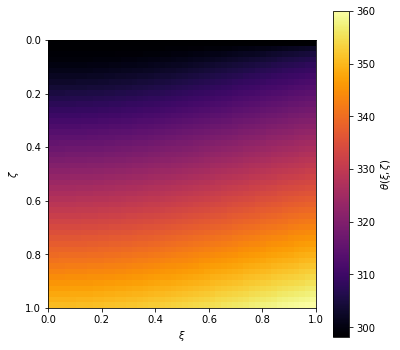

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(T), origin="upper", extent =[0, 1, 1, 0], cmap = "inferno")
plt.colorbar(label=r"$\theta(\xi,\zeta)$")
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\zeta$')
# plt.ylim(1,0)
# plt.xlim(0,1)
plt.show()

Se puede observar un perfil bidimensional de temperatura, en donde la temperatura máxima se alcanza en la intersección del plano de salida de la tubería y la pared del tanque. 

Para comprender mejor la variación de los perfiles de temperatura, se graficará el perfil de temperatura en función del radio en distintas secciones transversales al flujo. Esto implica graficar un perfil radial para un valor de coordenada axial, $z$, dado.

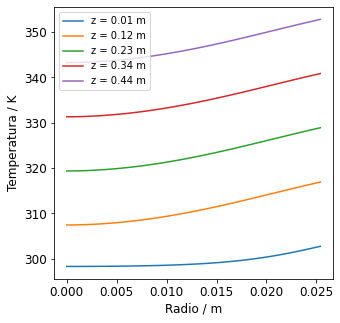

In [6]:
# Se crea una nueva figura
plt.figure(figsize=[5,5])

# Se grafica un perfil para espaciamientos igual a 10*dz

for i in range(1,len(z),10):
    plt.plot(r, T[:,i], label="z = %.2f m"%z[i])

# Títulos de ejes y estética
plt.xlabel('Radio / m', size = 12)
plt.ylabel('Temperatura / K', size = 12)
plt.tick_params(labelsize=12)

# Generación de leyendas
plt.legend()

plt.show()

Escogimos un número de Reynolds lo suficientemente bajo para que el perfil se desarrolle completamente. Observamos que a medida que la distancia desde el inicio aumenta, los perfiles de temperatura tienen la misma forma y se desplazan linealmente hacia arriba.

### Paso 7: Graficar el flux molecular de calor sobre el perfil de temperatura

Se deben calcular los flux de calor molecular en las dos dimensiones para cada punto de la grilla. Para esto se utiliza la ley de Fourier en ambas direcciones:

$$ \left( \frac{q_r}{A} \right) = -k \frac{\partial T}{\partial r} $$

$$ \left( \frac{q_z}{A} \right) = -k \frac{\partial T}{\partial z} $$

Es necesario discretizar estos fluxes, mediante aproximaciones de segundo orden para los puntos centrales de la grilla se tiene:

$$ \left( \frac{q_r}{A} \right) = -k \frac{T_{i+1,j} - T_{i-1,j}}{2\Delta r} $$

$$ \left( \frac{q_z}{A} \right) = -k \frac{T_{i,j+1} - T_{i,j-1}}{2\Delta z} $$

En el borde inferior ($z = L$) se utiliza la diferencia central para cacular el flux en $r$, sin embargo, para el flux en $z$ se necesita la diferencia discreta de segundo orden hacia atrás para la derivada.

$$ \left( \frac{q_z}{A} \right)_{i,L} = -k \frac{3 T_{i,L} - 4 T_{i,L-1} + T_{i,L-2}}{2 \Delta z}$$

De forma similar para el borde superior ($z = 0$) se necesita la diferencia discreta de segundo orden hacia adelante para la derivada.

$$ \left( \frac{q_z}{A} \right)_{i,0} = -k \frac{-3 T_{i,0} + 4 T_{i,1} - T_{i,2}}{2 \Delta z}$$

Para los bordes izquierdo ($r = 0$) y derecho ($r = R$), el componente en $r$ del flux.

$$ \left( \frac{q_r}{A} \right)_{0,j} = -k \frac{-3 T_{0,j} + 4 T_{1,j} - T_{2,j}}{2 \Delta r}$$

$$ \left( \frac{q_r}{A} \right)_{R,j} = -k \frac{3 T_{R,j} - 4 T_{R-1,j} + T_{R-2,j}}{2 \Delta r}$$


Se implementan las fórmulas para el cálculo de los fluxes.

Ubicando los fluxes sobre el gráfico de concentración $T(r,z)$.

### Desafío:
Implemente la solución analítica al perfil de temperatura obtenida en la Clase 12 y compárela con la solución numérica derivada en este Notebook.

## Referencias

https://primer-computational-mathematics.github.io/book/c_mathematics/numerical_methods/6_Solving_PDEs_SOR.html

Stability of Successive Over Relaxation: https://en.wikipedia.org/wiki/Successive_over-relaxation